#### Imports

In [3]:
pip install openpyxl matplotlib tensorflow numpy pandas seaborn stumpy nptdms plotly tqdm darts scikit-learn nbformat ipykernel jupyter icecream mlflow -q

Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
import shutil
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import statistics
from icecream import ic
import torch
# import stumpy
import random
from nptdms import TdmsFile
from nptdms import tdms
from pprint import pprint
from tqdm import tqdm
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
import mlflow

from collections import defaultdict

from IPython.display import SVG, display

In [2]:
# Take tdms file_name list and returns a dataframe list of their 'Raw Data'

def load_tdms_data(file_names, write=False, max = -1):
    dataframe_list = []
    for file in tqdm(file_names):
        if max != -1:
            if len(dataframe_list) >= max:
                break
        tdms_file = TdmsFile.read(file)
        group = tdms_file["Raw Data"]
        df = group.as_dataframe()
        dataframe_list.append(df)
        # print('SN: ', file.strip('_'))
        if write:
            file = file.replace(".tdms", "")
            df.to_excel(str(file)+".xlsx")
    return dataframe_list

In [4]:
# Create ts_dict which has the structure:
# ts_dict = {
#     'ts_aggregated_step_1' : [ts_list_step_1],
#     'ts_aggregated_step_2' : [ts_list_step_2],
#      ....
# }

def ts_dict_attr_per_step(df_list, attribute, spindle_type='Aggregato', append_nan=True):
    ts_dict = {}
    match spindle_type:
        case 'Aggregato':
            steps = 5
        case 'ES951':
            steps = 8
        case _ :
            return
        
    for index, df in enumerate(df_list):
        for step in range(1, steps+1):
            variable_name = f"ts_aggregated_step_{step}"
            df_step = df[df['Step'] == step]

            attr = np.array(df_step[attribute])
            if append_nan:
                attr = np.append(attr, np.nan)
            try:
                # ts_dict[variable_name].append(norm_temp)
                ts_dict[variable_name].append(attr)
            except:
                ts_dict[variable_name] = []
                # ts_dict[variable_name].append(norm_temp)
                ts_dict[variable_name].append(attr)
    return ts_dict

In [5]:
# Plot "traces_to_visualize" traces representing a specific attribute of the ts_list, for a specific step

def plot_attr_step(df_list, attribute, step='all', spindle_type='Aggregato', traces_to_visualize='all', consensus_motif=None):

    fig = go.Figure()

    longest_df = max([x for x in df_list], key=len)

    
    if isinstance(step, int):
        ts_dict = ts_dict_attr_per_step(df_list, attribute, spindle_type, False)
        ts_list = ts_dict['ts_aggregated_step_' + str(step)]
        fig.add_trace(go.Scatter(y=longest_df[longest_df['Step'] == step]['Speed_S3_BUS']/250, mode='lines', line=dict(dash='dash'), name='Speed_S3_BUS'))
    
    else: # all steps
        
        ts_list = []
        for df in df_list:
            ts_list.append(df[attribute])
        
        fig.add_trace(go.Scatter(y=longest_df['Step']*10, mode='lines', line=dict(dash='dash'), name='Step'))
        fig.add_trace(go.Scatter(y=longest_df['Speed_S3_BUS']/250, mode='lines', line=dict(dash='dash'), name='Speed_S3_BUS'))
    

    match traces_to_visualize:
        case 'all':
            traces_to_visualize = len(ts_list)
        case int():
            pass
        case _ : 
            print('traces_to_visualize must be either the string "all" or an integer value.')
        
    
    if consensus_motif is not None:
        fig.add_trace(go.Scatter(y=consensus_motif, mode='lines', line={'width': 4}, name='Consensus Motif'))


    for i in range(traces_to_visualize):
        try:
            ts = ts_list[i]
            fig.add_trace(go.Scatter(y=ts, mode='lines', name='trace ' + str(i)))
        except:
            print('Out of range, displaying ', i , ' plots.')
            break
        
    fig.update_layout(
        title='SPINDLE: ' + spindle_type + '\t\t\tSTEP: ' + str(step) + '\t\t\tATTRIBUTE: ' + attribute + '\t\t\t# OF TRACES: ' + str(traces_to_visualize)
    )
    fig.show()

In [6]:
def consensus_motif(ts_dict, step, m = None, plot=False):
    Ts = ts_dict['ts_aggregated_step_' + str(step)]
    if m is None:
        m = len(min(Ts, key=len))
    print('m = ', m)
    radius, Ts_idx, subseq_idx = stumpy.ostinato(Ts, m)
    print(f'Found Best Radius {np.round(radius, 2)} in time series {Ts_idx} starting at subsequence index location {subseq_idx}.')
    consensus_motif = Ts[Ts_idx][subseq_idx : subseq_idx + m]
    nn_idx = []
    fig = go.Figure()
    for i, T in enumerate(Ts):
        nn_idx.append(np.argmin(stumpy.core.mass(consensus_motif, T)))
        lw = 1
        label = None
        if i == Ts_idx:
            lw = 5
            label = 'Consensus Motif'
        fig.add_trace(go.Scatter(y=T[nn_idx[i] : nn_idx[i]+m], line={'width':lw}, name=label))


    # Show the plot
    if plot:
        fig.update_layout(
            title = 'Consensus Motif - STEP: ' + str(step) + ''
        )
        fig.show()
    return consensus_motif

##### distribution_error_types

In [5]:
# Create a list of dict which has the structure:
# err_list = [... {
#     'Count' : 1,
#     'Error' : 'Errore flussostato chiller',
#     'Error Code' : 8134,
#     'tdms_dict' : {
#           'step 1' : [H2492598201 AM, H25244902 PM, ...],
#           'step 2' : [...], 
#           ...
#      }
#      
# } 
# ... ]

def distribution_error_dict(spindle_type='Aggregato', plot=True):
    match spindle_type:
        case 'Aggregato':
            error_dict = 'aggregati_error_dict.json'
            steps = 5
        case 'ES951':
            error_dict = 'ES951_error_dict.json'
            steps = 8
        case _:
            print('Insert either type "Aggregato" or "ES951"')
            return
    
    with open(error_dict) as json_file:
        data = json.load(json_file)
    
    unique_errors = {(x['Error Code'], x['Error'].split('\n')[4]) for x in data.values()}
    error_counts = defaultdict(int)
    for elem in data.values():
        error_counts[elem['Error Code']] += 1

    error_check = [{'Error Code': elem[0], 'Error': elem[1], 'Count': error_counts[elem[0]]} for elem in unique_errors]


    for x in error_check:
        x['tdms_dict'] = {}
        for step in range(steps+1):
            tmp_step = 'step ' + str(step)
            x['tdms_dict'][tmp_step] = [y for y in data if data[y]['Error Code'] == x['Error Code'] 
                                                   and data[y]['Failing Step'] == step]
            if x['tdms_dict'][tmp_step] == []:
                x['tdms_dict'].pop(tmp_step)
    

    if plot:
        print('----------------> Error Distribution Over Spindles Type "', spindle_type, '"\n')
        pprint(error_check)

    return error_check

#### Varibales

##### Utils for variables

In [6]:
# Take error_code (and optionally step) as input and returns all the breakins

def df_list_from_err_dict(error_code, step=None, spindle_type='Aggregato'):
    err_list = distribution_error_dict(spindle_type, plot=False)
    base_path_aggregato_failed = 'wetransfer_fail-rodaggi_2023-10-20_1232/Aggregato'
    f = lambda str : os.path.join(base_path_aggregato_failed, str + '.tdms')

    file_names = []
    for s in range(10):
        try:
            file_names.append(list(map(f, [x['tdms_dict']['step ' + str(step)] for x in err_list if x['Error Code'] == error_code][0])))
        except KeyError:
            continue

    file_names = [item for sublist in file_names for item in sublist]

    if step is not None and isinstance(step, int):
        try: 
            file_names = list(map(f, [x['tdms_dict']['step ' + str(step)] for x in err_list if x['Error Code'] == error_code][0]))
        except KeyError as err:
            print(err)
            return None

    return load_tdms_data(file_names)

In [7]:
attr_dict = {
    1 : 'Speed_S3_BUS',
    2 : 'Itot',
    3 : 'Tamb',
    4 : 'Tba',
    5 : 'NHR',
    6 : 'Tdut1',
    7 : 'Tdut2',
    8 : 'Tdut3',
    9 : 'Vib_EM',
    10 : 'Vib_AGG_Lato',
    11 : 'Vib_AGG_Fondo',
    12 : 'Noise_dbA'
}

success_breakin_aggregato = glob.glob('Log aggregati/*.tdms')
fail_breakin_aggregato = glob.glob('wetransfer_fail-rodaggi_2023-10-20_1232/Aggregato/*.tdms')
fail_breakin_es951 = glob.glob('wetransfer_fail-rodaggi_2023-10-20_1232/ES951/*.tdms')

# DF LISTS
df_success_breakin_aggregato = load_tdms_data(success_breakin_aggregato)
df_fail_breakin_aggregato = load_tdms_data(fail_breakin_aggregato)
df_fail_breakin_es951 = load_tdms_data(fail_breakin_es951)


df_fail_breakin_aggregato_vib_lato_dict = {}
df_fail_breakin_aggregato_vib_fondo_dict = {}

for step in range(6):
    df_list_per_step_vib_lato = df_list_from_err_dict(7704,step)
    df_list_per_step_vib_fondo = df_list_from_err_dict(7705, step) 
    if df_list_per_step_vib_lato is not None:
        df_fail_breakin_aggregato_vib_lato_dict['step ' + str(step)] = df_list_per_step_vib_lato      # 'Vibrazione Accelerometro Lato Fuori dai limiti'
    if df_list_per_step_vib_fondo is not None:
        df_fail_breakin_aggregato_vib_fondo_dict['step ' + str(step)] =  df_list_per_step_vib_fondo   # 'Vibrazione Accelerometro Fondo Fuori dai limiti'

100%|██████████| 20/20 [00:00<00:00, 275.08it/s]


'step 0'
'step 0'
'step 1'
'step 1'


100%|██████████| 6/6 [00:00<00:00, 47.04it/s]

'step 5'
'step 5'


In [10]:
ATTRIBUTE = attr_dict[10]
STEP = 4
# DF_LIST = df_fail_breakin_aggregato_vib_fondo
SPINDLE_TYPE = 'Aggregato' # 'ES951'

In [11]:
error_dict_aggregati = distribution_error_dict(plot=True)
print('\n')
error_dict_es951 = distribution_error_dict(spindle_type='ES951', plot=True)

----------------> Error Distribution Over Spindles Type " Aggregato "

[{'Count': 3,
  'Error': 'Errore flussostato chiller',
  'Error Code': 7011,
  'tdms_dict': {'step 0': ['H630211700_2023034845_2023.09.06_09.14.39 AM',
                           'H630211700_2022008602_2022.02.22_07.17.24 AM'],
                'step 1': ['H630211700_2023037638_2023.09.26_07.47.31 AM']}},
 {'Count': 1,
  'Error': "Test interrotto dall'utente",
  'Error Code': 7002,
  'tdms_dict': {'step 3': ['H630211700_2023003392_2023.01.25_06.44.11 PM']}},
 {'Count': 1,
  'Error': 'TC troppo bassa a fine prova',
  'Error Code': 7403,
  'tdms_dict': {'step 5': ['H630211700_2022044486_2022.08.29_05.52.59 PM']}},
 {'Count': 10,
  'Error': 'Vibrazione Accelerometro Lato Fuori dai limiti',
  'Error Code': 7704,
  'tdms_dict': {'step 2': ['H630211700_2023000724_2023.01.11_06.40.26 AM',
                           'H630211700_2023001713_2023.01.16_06.03.19 PM'],
                'step 3': ['H630211700_2023001713_2023.01.16_

In [12]:
plot_attr_step(
    df_list=df_fail_breakin_aggregato_vib_lato_dict['step ' + str(STEP)],
    attribute=ATTRIBUTE,
    step=STEP,
    traces_to_visualize='all',
    # consensus_motif=consensus_motif(ts_dict_attr_per_step(df_success_breakin_aggregato, ATTRIBUTE), STEP)
)
plot_attr_step(
    df_list=df_fail_breakin_aggregato_vib_lato_dict['step ' + str(STEP)],
    attribute=attr_dict[4],
    step=STEP,
    traces_to_visualize=3,
    # consensus_motif=consensus_motif(ts_dict_attr_per_step(df_success_breakin_aggregato, ATTRIBUTE), STEP)
)

plot_attr_step(
    df_list=df_success_breakin_aggregato,
    attribute=attr_dict[4],
    step=STEP,
    traces_to_visualize=3,
    # consensus_motif=consensus_motif(ts_dict_attr_per_step(df_success_breakin_aggregato, ATTRIBUTE), STEP)
)



# plot_attr_step(consensus_motif_success_aggregato, ts_dict, step='all', traces_to_visualize='all')

# Multiple Multivariate Timeseries Forecasting and Anomaly Detection

#### Imports

In [8]:
from darts.models import XGBModel, NBEATSModel, NHiTSModel, TFTModel, TCNModel, TiDEModel, BlockRNNModel, TransformerModel, CatBoostModel, LightGBMModel, RNNModel
from darts import TimeSeries
from sklearn import preprocessing

from darts.dataprocessing import dtw
from darts.dataprocessing.transformers import Scaler
from darts.utils import timeseries_generation as tg
from darts.utils.missing_values import fill_missing_values
from darts.datasets import SunspotsDataset
from darts.metrics import dtw_metric, mae, mape, mse, smape, rmse, mase, ope
from darts.models import MovingAverageFilter
from darts import concatenate
from darts.explainability import TFTExplainabilityResult, TFTExplainer

In [14]:
df1 = df_success_breakin_aggregato[0].loc[:, ["Speed_S3_BUS"]]
df2 = df_success_breakin_aggregato[1].loc[:, ["Speed_S3_BUS"]]

ts1 = TimeSeries.from_dataframe(df1)
ts2 = TimeSeries.from_dataframe(df2)

print(ts1.time_index)
print(ts2.time_index)

print(ts1.duration)
# ts1.plot()

RangeIndex(start=0, stop=20979, step=1, name='time')
RangeIndex(start=0, stop=20981, step=1, name='time')
20978


#### Dataframe Elaboration

In [9]:
def align_df(min, df):
    x =  len(df) - min
    if x > 0:
        return df[:-x]
    return df

In [10]:
df_list_success = [df.loc[:, ["Itot", "Tba", "Vib_AGG_Lato", "Vib_AGG_Fondo", "Speed_S3_BUS", "Step"]] for df in df_success_breakin_aggregato]
df_list_failed = [df.loc[:, ["Itot", "Tba", "Vib_AGG_Lato", "Vib_AGG_Fondo", "Speed_S3_BUS", "Step"]] for df in df_fail_breakin_aggregato]


# df_list_success = [df.loc[:, ["Tba","Tamb"]] for df in df_success_breakin_aggregato]
# df_list_failed = [df.loc[:, ["Tba","Tamb"]] for df in df_fail_breakin_aggregato]


# Find the maximum value for the 'your_column' in each dataframe
for col in df_list_failed[0].columns:

    max_values = [df[col].max() for df in df_list_success]
    min_values = [df[col].min() for df in df_list_success]

    overall_max_value = ic(col, max(max_values))
    overall_min_value = ic(col, min(min_values)) 

# Downsampling (every 1 seconds)

downsampling = 1
df_list_success = [x.iloc[::downsampling] for x in df_list_success]
df_list_failed = [x.iloc[::downsampling] for x in df_list_failed]



min_len = len(min(df_list_success, key=len))
align_fun = lambda df : align_df(min_len, df)
df_list_success = list(map(align_fun, df_list_success))

ic(len(max(df_list_success, key=len)))
ic(len(min(df_list_success, key=len)))

# Find the overall maximum value across all dataframes
# overall_max_value = max(max_values)
# overall_min_value = min(min_values)
# print(overall_max_value, overall_min_value)

# Select columns with 'float64' dtype  
# float64_cols = list(df_list_success[0].select_dtypes(include='float64'))

# The same code again calling the columns
# df_list_success = [x[float64_cols].astype('float32') for x in df_list_success]
# df_list_failed = [x[float64_cols].astype('float32') for x in df_list_success]



ts_list_success = [TimeSeries.from_dataframe(ts) for ts in df_list_success]
# ts_list_success_speed3 = [TimeSeries.from_dataframe(ts) for ts in df_list_success_speed3]
ts_list_failed = [TimeSeries.from_dataframe(ts) for ts in df_list_failed]
# ts_list_failed_speed3 = [TimeSeries.from_dataframe(ts) for ts in df_list_failed_speed3]


ts_list = ts_list_success + ts_list_failed

ic(len(ts_list))

ts_list = [ts for ts in ts_list if ts.duration > 0]

ic(len(ts_list))

seed = 1
random.seed(seed)
random.shuffle(ts_list_success)

split_point = int(len(ts_list_success) * 0.8)

train_set, test_set = ts_list_success[:split_point], ts_list_success[split_point:]

scaler = preprocessing.MinMaxScaler((0,1), clip=True)
train_scaler = Scaler(scaler, global_fit=True)
train = train_scaler.fit_transform(train_set)
test = train_scaler.transform(test_set)

train_speed3 = [ts['Speed_S3_BUS'] for ts in train]
test_speed3 = [ts['Speed_S3_BUS'] for ts in test]

train_step = [ts['Step'] for ts in train]
test_step = [ts['Step'] for ts in test]

train = [ts.drop_columns(['Speed_S3_BUS', 'Step']) for ts in train]
test = [ts.drop_columns(['Speed_S3_BUS', 'Step']) for ts in test]

max_len_train = ic(len(max(train, key=len)))
min_len_train = ic(len(min(train, key=len)))

max_len_test = ic(len(max(test, key=len)))
min_len_test = ic(len(min(test, key=len)))


# train, val = [x.split_after(0.7)[0] for x in ts_list_success_pre], [x.split_after(0.7)[1] for x in ts_list_success_pre]
# past_cov, future_cov = [x.split_after(0.7)[0] for x in ts_list_success_speed3_pre], [x.split_after(0.7)[1] for x in ts_list_success_speed3_pre]
# print(len(train[0]), len(val[0]), len(past_cov[0]), len(future_cov[0]))
# for i in range(len(ts_list_success)):
    #ts_list_success_pre[i].plot()
    #train[i].plot()
    #val[i].plot()
    #ts_list_success_speed3_pre[i].plot()
# ts_list_success[1].plot()


ic| col: 'Itot', max(max_values): 16.0
ic| col: 'Itot', min(min_values): 0.0
ic| col: 'Tba', max(max_values): 86.13297840957175
ic| col: 'Tba', min(min_values): 26.751418837091197
ic| col: 'Vib_AGG_Lato', max(max_values): 14.32910981902387
ic| col: 'Vib_AGG_Lato', min(min_values): 0.009767476818524301
ic| col: 'Vib_AGG_Fondo', max(max_values): 13.390849606948903
ic| col: 'Vib_AGG_Fondo', min(min_values): 0.007810486829839646
ic| col: 'Speed_S3_BUS', max(max_values): 12004.0
ic| col: 'Speed_S3_BUS', min(min_values): 0.0
ic| col: 'Step', max(max_values): 5.0
ic| col: 'Step', min(min_values): 1.0
ic| len(max(df_list_success, key=len)): 20957
ic| len(min(df_list_success, key=len)): 20957
ic| len(ts_list): 54
ic| len(ts_list): 54


ic| len(max(train, key=len)): 20957
ic| len(min(train, key=len)): 20957
ic| len(max(test, key=len)): 20957
ic| len(min(test, key=len)): 20957


In [11]:
def log_model(model_name, model_params, data_info):
    path = "models/log.txt"
    with open(path, 'a') as file:
        string = "\n\n---- " + model_name  + " Parameters ----\n"
        string += str(model_params)
        string += "\n\n---- Data Info ---- \n"
        string += str(data_info)
        file.write(string)
        return

In [12]:
data_info = {
    "columns" : train[0].columns,
    "downsampling" : downsampling,
}

model_name = "XGBModel_8"

model_params = {
    # "input_chunk_length" : 500,
    "output_chunk_length" : 100,
    "lags" : 800,
    "lags_past_covariates" : 800,
    # "lags_future_covariates" : (0,200),
    # "future_covariates" : True
    # "past_covariates" : False
    # "n_epochs" : 100,
    # "n_rnn_layers" : 2,
    "likelihood" : 'poisson',
    # "dropout" : 0.0001,
    # "support_multivariate": True,
    "multi_models" : False,
    "verbosity" : 3, # default 1
    'max_depth' : 6, # default 6
    
}

In [19]:
ic(len(train_speed3[3]))

ic| len(train_speed3[3]): 20957


20957

In [27]:
model = XGBModel(
    lags=model_params['lags'],       
    # input_chunk_length=model_params["input_chunk_length"],
    lags_past_covariates=model_params['lags_past_covariates'],
    # lags_future_covariates=(0,100),
    output_chunk_length=model_params['output_chunk_length'],
    # training_length=80,
    # model=model_params["model"],
    # likelihood=model_params['likelihood'],
    multi_models=model_params["multi_models"],
    likelihood=model_params['likelihood'],
    verbosity = model_params['verbosity'],
    max_depth=model_params['max_depth'],
    device='gpu',
    validate_parameters=True,
    # dropout=0.0001,
    # n_epochs=model_params["n_epochs"],
    # n_rnn_layers=model_params["n_rnn_layers"],
    # model_name=model_params["model_name"],
    # work_dir='models',
    # save_checkpoints=True,
    # hidden_dim=256,
    # supports_multivariate=True,
    # n_rnn_layers = 3,
    # force_reset=True

)

# ts_list = concatenate(ts_list, ignore_time_axis=True)
# print(len(train), len(train[30]), len(past_cov), len(past_cov[30]))
model.fit(
    series=train,
    # past_covariates=train_speed3,
    past_covariates=train_speed3,
    # future_covariates=past_cov_train,
    # future_covariates=ts_list_success_speed3_pre, 
    verbose=True,
)

[16:31:07] ======== Monitor (0): HostSketchContainer ========
[16:31:07] AllReduce: 0.293204s, 1 calls @ 293204us

[16:31:07] MakeCuts: 0.302826s, 1 calls @ 302826us

[16:31:07] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[16:31:07] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
[16:31:07] ======== Monitor (0):  ========
[16:31:07] InitCompressedData: 0.014841s, 1 calls @ 14841us

[16:31:17] ======== Monitor (0): Learner ========
[16:31:17] Configure: 0.018459s, 1 calls @ 18459us

[16:31:17] EvalOneIter: 0.000205s, 100 calls @ 205us

[16:31:17] GetGradient: 0.070431s, 100 calls @ 70431us

[16:31:17] PredictRaw: 8.6e-05s, 100 calls @ 86us

[16:31:17] UpdateOneIter: 10.092s, 100 calls @ 10091955us

[16:31:17] ======== Monitor (0): GBTree ========
[16:31:17] BoostNewTrees: 10.0013s, 100 calls @ 10001322us

[16:31:17] CommitModel: 2e-05s, 100 calls @ 20us

[16:31:17] ======== Device 0 Memory Allocations:  ========
[16:31:17] Peak memory usage: 1

XGBModel(lags=800, lags_past_covariates=800, lags_future_covariates=None, output_chunk_length=100, add_encoders=None, likelihood=poisson, quantiles=None, random_state=None, multi_models=False, use_static_covariates=True, verbosity=3, max_depth=6, device=gpu, validate_parameters=True)

In [28]:
def save_model(model, name, save=False):
    if save:
        model.save(f'models/{name}')
        return
    
save_model(model, model_name, True)
log_model(model_name, model_params, data_info)

In [13]:
# model = XGBModel.load_from_checkpoint(model_name='BlockRNN__100_4', work_dir='models', best=False)
model = XGBModel.load('models/XGBModel_8')
# model = TFTModel.load_from_checkpoint(model_name='TFTModel_100_2', work_dir='models', best=False)
# model = RNNModel.load_from_checkpoint(model_name= 'RNN_LSTM_20_4', work_dir='models', best=False)

pprint(model._model_params)

OrderedDict([('lags', 800),
             ('lags_past_covariates', 800),
             ('lags_future_covariates', None),
             ('output_chunk_length', 100),
             ('add_encoders', None),
             ('likelihood', 'poisson'),
             ('quantiles', None),
             ('random_state', None),
             ('multi_models', False),
             ('use_static_covariates', True),
             ('verbosity', 3),
             ('max_depth', 6),
             ('device', 'gpu'),
             ('validate_parameters', True)])


#### Per-step prediction

In [ ]:
df_to_check = 1
ts = test[df_to_check]
ts_step = test_step[df_to_check]
ts_speed_3 = test_speed3[df_to_check]

assert(len(ts) == len(ts_step) == len(ts_speed_3))

attr_list = ['Tba', 'Itot', 'Vib_AGG_Lato', 'Vib_AGG_Fondo']
# Convert the time series to a Pandas DataFrame
df = ts_step.pd_dataframe()

print(len(df))
# Use the groupby method to group consecutive equal values
groups = df.groupby((df['Step'] != df['Step'].shift()).cumsum())

# Calculate the length of each group
lengths = groups.size()

start_idx = 0
end_idx = 0

print(lengths.values)

predictions_step_list = [] 
train_step_list = []
test_step_list = [] 

for step in range(5):
    end_idx += int(lengths.values[step]) 

    # print(start_idx, end_idx)
    sliced = ts.slice(start_idx, end_idx)
    sliced_speed = ts_speed_3.slice(start_idx, end_idx)


    # sliced_speed = sliced_speed.slice(0, model_params['lags'])

    # input_per_step, ground_per_step = sliced.split_before(model_params['lags'])
    # input_per_step, ground_per_step = sliced.split_before(0.296) # is  working with 500
    input_per_step, ground_per_step = sliced.split_before(start_idx + model_params['lags'] + model_params['output_chunk_length']) 

    # print(input_per_step.duration, input_per_step.get_index_at_point(400),)

    # train_per_step = sliced.slice(0, model_params['lags'])
    # test_per_step = sliced.slice(model_params['lags'], int(lengths.values[step]))

    ic(len(sliced_speed))
    ic(len(input_per_step), len(ground_per_step))
    start_idx += int(lengths.values[step]) 

    ic(model.extreme_lags)

    
    prediction = model.predict(
        n=len(ground_per_step), 
        series=input_per_step,
        past_covariates=sliced_speed,
    )

    train_step_list.append(input_per_step)
    test_step_list.append(ground_per_step)
    predictions_step_list.append(prediction)
    

# Assuming attr_list, predictions_step_list, lengths, train_step_list, test_step_list, and ope are defined
"""
for attr in attr_list:
    fig = go.Figure()
    vertical_ax_step_at = 0
    
    for step, p in enumerate(predictions_step_list):
        vertical_ax_step_at += lengths.values[step]

        # Scatter plot for train_step_list
        fig.add_trace(go.Scatter(
            x=train_step_list[step].time_index,
            y=list(train_step_list[step][attr].values()),
            mode='lines+markers',
            line=dict(color='purple')
        ))

        # Scatter plot for test_step_list
        fig.add_trace(go.Scatter(
            x=test_step_list[step].time_index,
            y=list(test_step_list[step][attr].values()),
            mode='lines+markers',
            line=dict(color='blue', dash='dash')
        ))

        # Scatter plot for predictions
        fig.add_trace(go.Scatter(
            x=p.time_index,
            y=list(p[attr].values()),
            mode='lines+markers',
            line=dict(color='green')
        ))

        # Vertical line at vertical_ax_step_at
        fig.add_shape(
            type="line",
            x0=vertical_ax_step_at,
            x1=vertical_ax_step_at,
            y0=0,
            y1=max(p[attr].values()),
            line=dict(color='red')
        )

        print('STEP:', step + 1, ",", "ATTR:", attr, 'OPE - Overall Percentage Error: ', ope(test_step_list[step][attr], p[attr]))

    # Update layout
    fig.update_layout(
        xaxis_title='Time',
        yaxis_title=attr,
    )

    # Show the plot
    fig.show()
"""




STEP: 1 , ATTR: Tba OPE - Overall Percentage Error:  2.7338042140311316
STEP: 2 , ATTR: Tba OPE - Overall Percentage Error:  15.750096619253156
STEP: 3 , ATTR: Tba OPE - Overall Percentage Error:  0.6189148225204825
STEP: 4 , ATTR: Tba OPE - Overall Percentage Error:  10.774343430854774
STEP: 5 , ATTR: Tba OPE - Overall Percentage Error:  2.7006992307358404
STEP: 1 , ATTR: Itot OPE - Overall Percentage Error:  0.9418870759444142
STEP: 2 , ATTR: Itot OPE - Overall Percentage Error:  1.3544818898836708
STEP: 3 , ATTR: Itot OPE - Overall Percentage Error:  1.5805302820496006
STEP: 4 , ATTR: Itot OPE - Overall Percentage Error:  1.3135630175687423
STEP: 5 , ATTR: Itot OPE - Overall Percentage Error:  0.21362044514501138
STEP: 1 , ATTR: Vib_AGG_Lato OPE - Overall Percentage Error:  9.141704247181528
STEP: 2 , ATTR: Vib_AGG_Lato OPE - Overall Percentage Error:  6.8376075053439855
STEP: 3 , ATTR: Vib_AGG_Lato OPE - Overall Percentage Error:  7.701893564037383
STEP: 4 , ATTR: Vib_AGG_Lato OPE 

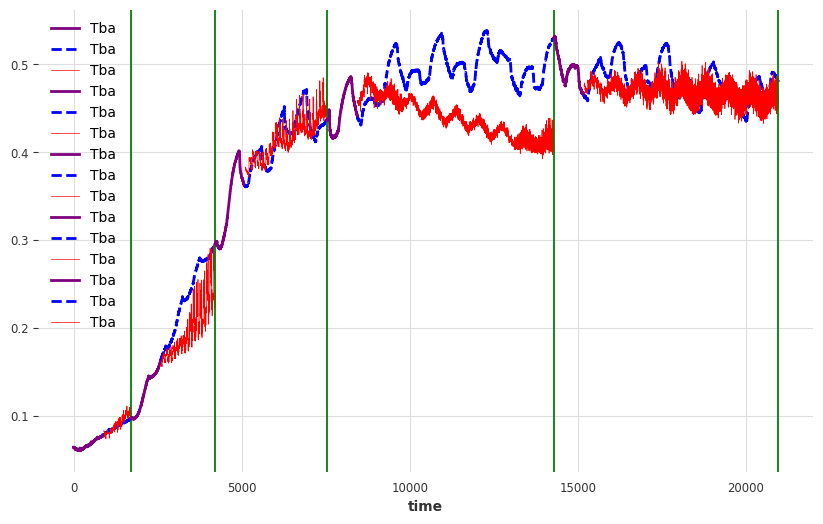

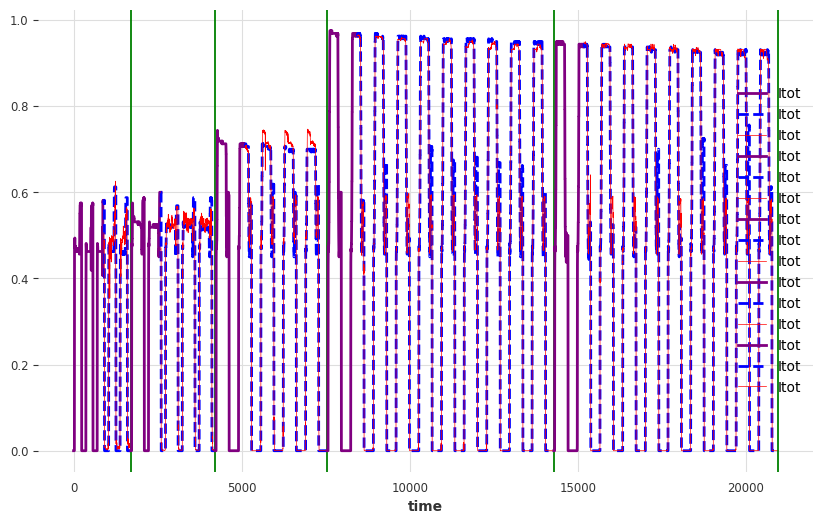

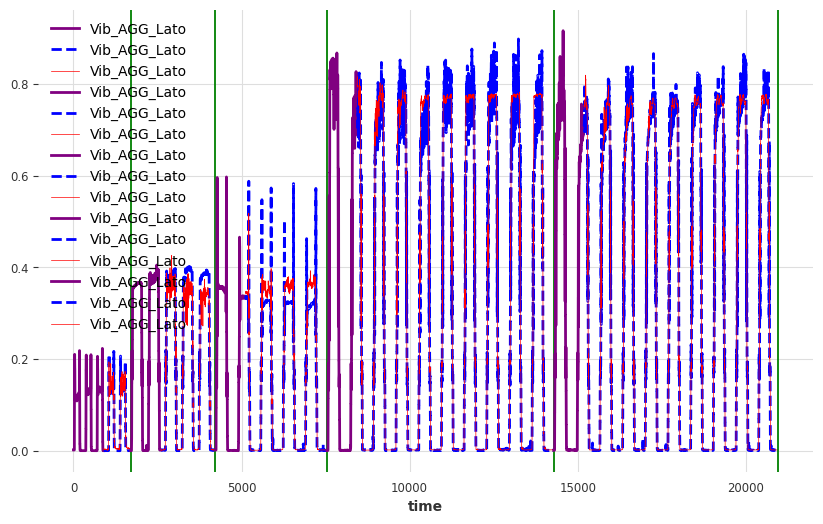

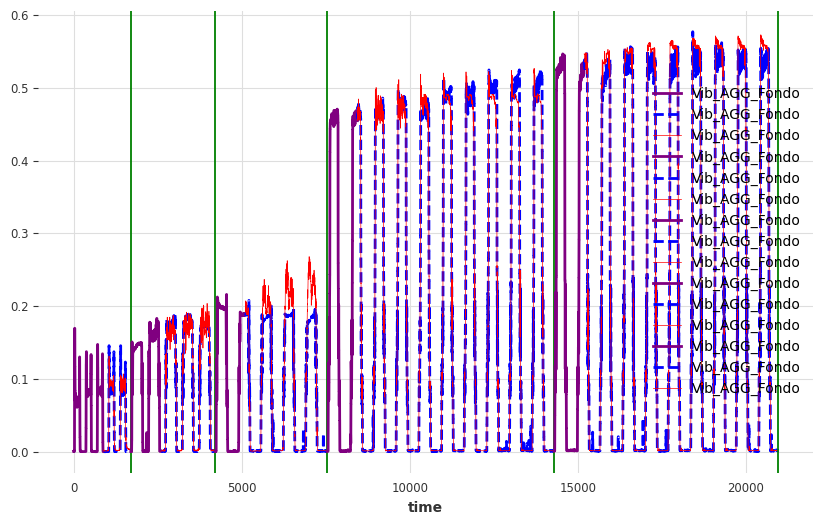

In [19]:
for attr in attr_list:
    plt.figure(figsize=(10, 6))
    vertical_ax_step_at = 0
    
    for step, p in enumerate(predictions_step_list):
        vertical_ax_step_at += lengths.values[step]
        train_step_list[step][attr].plot(color='purple')
        test_step_list[step][attr].plot(linestyle='dashed', color='blue')
        p[attr].plot(color = 'red', linewidth=0.5)
        plt.axvline(x = vertical_ax_step_at, color = 'g')
        print('STEP:', step+1, "," , "ATTR:", attr, 'OPE - Overall Percentage Error: ', ope(test_step_list[step][attr], p[attr]))

In [48]:
# Success first 31, failed last 23
df_to_check = 0
input_pred, ground_pred = test[df_to_check]._split_at(0.7)
ic(len(test_speed3[df_to_check]))

# train, test = ts_list_pre[df_to_check].split_after(0.8)[0], ts_list_pre[df_to_check].split_after(0.8)[1] 
prediction = model.predict(
    # n = 50,
    n=len(ground_per_step), 
    series=input_pred, 
    past_covariates=test_speed3[df_to_check],
    # future_covariates=test_speed3[df_to_check]
    # future_covariates=ts_list_success_speed3_pre[df_to_check]
)


# ts = ts_list_success
# ts.append(scaler.inverse_transform(prediction))


# pred_scaler = Scaler(global_fit=True)
# prediction_pre = pred_scaler.fit_transform(ts)[0]

# prediction_pre = pred_scaler.transform(prediction)
# prediction = scaler.fit_transform(prediction)


ic| len(test_speed3[df_to_check]): 20957


ic| len(prediction): 5772
ic| len(input_pred): 14670
ic| len(ground_pred): 6287


Tba OPE - Overall Percentage Error:  3.2860786706804648
Itot OPE - Overall Percentage Error:  0.043430040829163304
Vib_AGG_Lato OPE - Overall Percentage Error:  2.467824281047242
Vib_AGG_Fondo OPE - Overall Percentage Error:  3.455102882368999


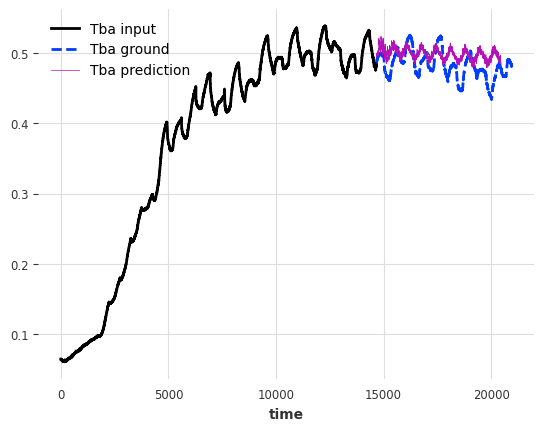

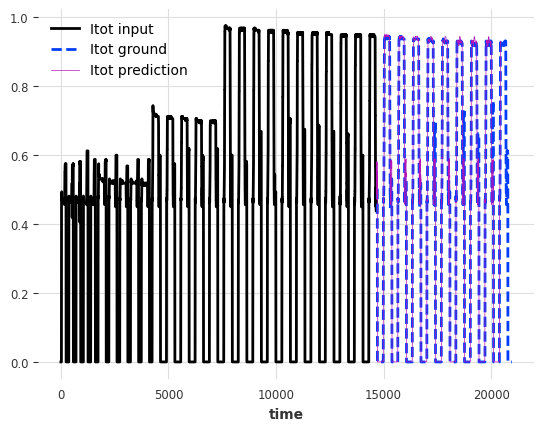

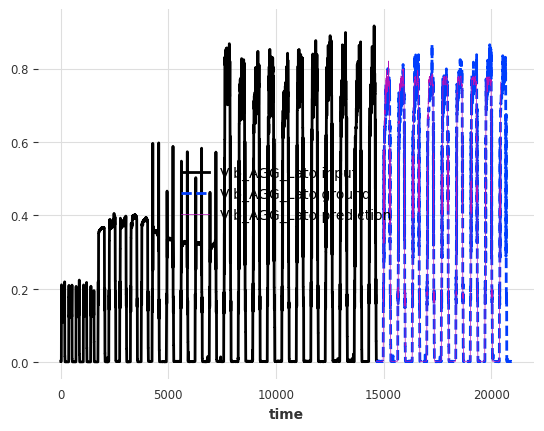

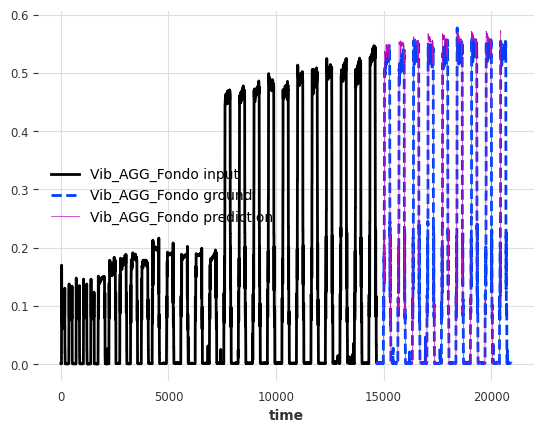

In [49]:
attr_list = ['Tba', 'Itot', 'Vib_AGG_Lato', 'Vib_AGG_Fondo']

ic(len(prediction))
ic(len(input_pred))
ic(len(ground_pred))

for attr in attr_list:
    # print(prediction[attr])
    input_pred[attr].plot(label = attr + ' input', new_plot=True)
    ground_pred[attr].plot(label = attr + ' ground', linestyle='dashed')
    prediction[attr].plot(label= attr + ' prediction', linewidth=0.5)
    # print(attr, 'MSE - Mean Squared Error:', mse(test_pred[attr], prediction[attr]))
    # print(attr, 'MAE - Mean Absolute Error:', mae(test_pred[attr], prediction[attr]))
    # print(attr, 'RMSE - Root MSE:', rmse(test_pred[attr], prediction[attr]))
    # print(attr, 'SMAPE- Symmetric Mean Absolute Percentage Error:', smape(test_pred[attr], prediction[attr]))
    # print(attr, 'MASE - Mean Absolute Scaled Error:', mase(test_pred[attr], prediction[attr], train_pred[attr]))
    print(attr, 'OPE - Overall Percentage Error: ', ope(ground_pred[attr], prediction[attr]))